In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
def sigmoid(t):
    v = 1 / (1 + np.exp(-t))
    return v


def stable(t):
    v = 0 * t
    return v


def decreasing(t):
    v = -sigmoid(10 * (t - 0.5))
    return v


def increasing(t):
    v = sigmoid(10 * (t - 0.5))
    return v


def moderate_freq(t):
    v = np.sin(6 * t)
    return v


def high_freq(t):
    v = np.sin(8 * t)
    return v


def low_freq(t):
    v = np.sin(4 * t)
    return v


def sampling(fn, times, phases):
    x = fn(times - phases)
    return x

In [3]:
# (phenotype, y_label, c_label)
phenotypes_1 = [(stable, 1, 1), (decreasing, 2, 2), (increasing, 2, 3)]
phenotypes_2 = [(moderate_freq, 1, 1), (high_freq, 2, 2), (low_freq, 2, 3)]

In [4]:
seed = 1212
rng = np.random.default_rng(seed=seed)

In [5]:
def gen_time_series(times, phases, phenotypes, rng, randomize=False):
    N, T = times.shape
    x = np.zeros((N, T, 1))
    y = np.zeros((N, T))
    c = np.zeros((N, T))

    start = 0
    subgroup_size = int(N / len(phenotypes))

    indicies = np.arange(0, N, dtype=int)
    if randomize:
        rng.shuffle(indicies)

    for i, (fn, y_label, c_label) in enumerate(phenotypes):
        end = min(N, start + subgroup_size)
        idx_sel = np.arange(start, end, dtype=int)
        idx = indicies[idx_sel]
        observation = sampling(fn, times[idx], phases[idx])
        x[idx, :, 0] = observation
        y[idx] = y_label
        c[idx] = c_label
        start = end

    x += 0.1 * rng.normal(size=(N, T, 1))
    return x, y, c

In [6]:
N = 400 * len(phenotypes_1)
T = 20
t_scale = 2
alpha = 3 * np.ones(T)
dt = rng.dirichlet(alpha, size=(N,))
times = t_scale * np.cumsum(dt, axis=1)
phases = rng.exponential(scale=0.3, size=(N, 1))

mask = np.ones_like(times)

In [8]:
x1, y1, c1 = gen_time_series(times, phases, phenotypes_1, rng, randomize=True)
# np.savez_compressed("data-sigmoid.npz", x = x1,t = times, y = y1, c=c1, mask=mask)

x2, y2, c2 = gen_time_series(times, phases, phenotypes_2, rng, randomize=True)
# np.savez_compressed("data-periodicity.npz", x = x2,t = times, y = y2, c=c2, mask=mask)

x = np.concatenate([x1, x2], axis=-1)
np.savez_compressed("data-mixed.npz", x=x, t=times, y=y2, c=c2, mask=mask)

In [9]:
data = np.load("data-mixed.npz")
t, x, y, c, mask = (
    data["t"],
    data["x"],
    data["y"],
    data["c"],
    data["mask"],
)

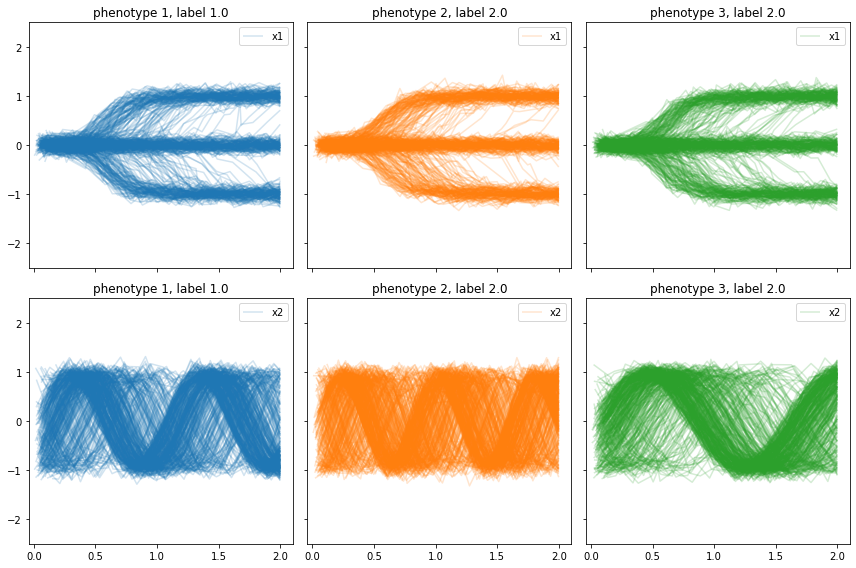

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(4 * 3, 4 * 2), sharex=True, sharey=True)
for x_dim in range(2):
    for p in range(3):
        ax = axs[x_dim, p]
        (idx,) = np.where(c[:, -1] == p + 1)
        line_segments = LineCollection(
            [np.column_stack([ti, xi]) for ti, xi in zip(t[idx], x[idx, :, x_dim])],
            label=f"x{x_dim+1}",
            color=plt.cm.tab10(p),
            alpha=0.2,
        )
        ax.add_collection(line_segments)
        ax.set_title(f"phenotype {p+1}, label {y[idx[0],-1]}")
        ax.legend()
        ax.set_xlim([-0.04, 2.1])
        ax.set_ylim([-2.5, 2.5])
fig.tight_layout()

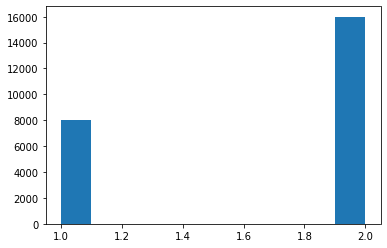

In [11]:
_ = plt.hist(y.flatten())